c:\Users\quant\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8923 - loss: 0.2207 - val_accuracy: 0.9719 - val_loss: 0.0795
Epoch 2/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9915 - loss: 0.0273 - val_accuracy: 0.9745 - val_loss: 0.0763
Epoch 3/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9960 - loss: 0.0159 - val_accuracy: 0.9731 - val_loss: 0.0918
Epoch 4/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9975 - loss: 0.0092 - val_accuracy: 0.9719 - val_loss: 0.1318
Epoch 5/5
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - accuracy: 0.9985 - loss: 0.0047 - val_accuracy: 0.9706 - val_loss: 0.1337
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9703 - loss: 0.1400
Validation Accuracy for News: 97.06%
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Precision: 0.98
Recall: 0.97
F1 Score: 0.97


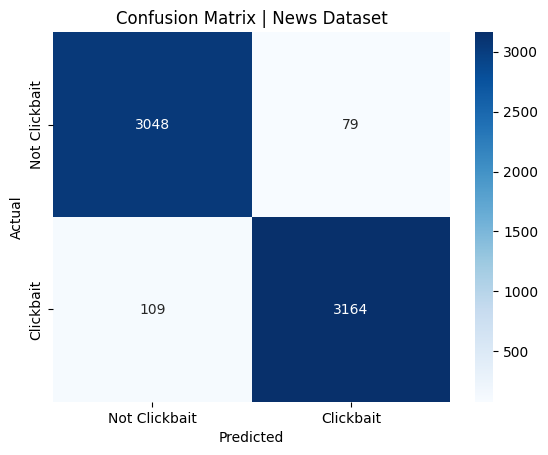

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7058 - loss: 1.7944  
Validation Accuracy on Youtube dataset (with News tokenizer/model): 66.17%
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Precision: 0.64
Recall: 0.73
F1 Score: 0.69


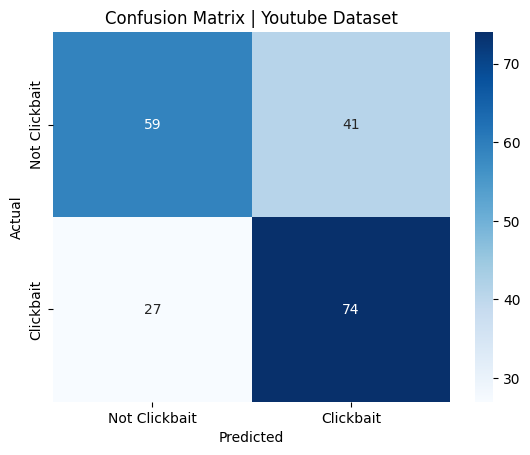

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import seaborn as sns
import matplotlib.pyplot as plt

#Read in the data into pandas dataframes. You may need to change this to your local path and the name to whatever you named the file.
news_df = pd.read_csv('clickbait_data.csv')
youtube_df = pd.read_csv('youtube_dataset.csv')

#Clean the data. Make all text lower and remove anything that isn't a number of letter.
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text

#To train the model. We pass the dataframe, the name of the column for the actual titles we are checking, 
# the name of the title of the clickbait column, and the dataset.
def train_model(df, titles, clickbait_title, dataset):
    #clean the dataset using the function we defined above
    df['clean_headline'] = df[titles].apply(clean_text)
    #Tokenize the data. We are using a max vocab of 10k words, everything else isn't a word
    tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
    tokenizer.fit_on_texts(df['clean_headline'])
    sequences = tokenizer.texts_to_sequences(df['clean_headline'])
    padded_sequences = pad_sequences(sequences, maxlen=20, padding='post')

    #Get labels (weather it is clickbait or not)
    labels = np.array(df[clickbait_title])

    #Split data into training and validation using 80-20 train test validate set.
    X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

    # Build the model. Input is our vocab size, output is 64 dimension vector. It expects an input length of 20 
    model = Sequential([
        Embedding(input_dim=10000, output_dim=64, input_length=20),
        LSTM(64), #LSTM model with 64 memory cells
        Dense(1, activation='sigmoid') #Ouput prediction, weather it is clickbait or not. It squashes output probability to between 0 and 1
    ])

    #Compile and summarize model using adam optimizer and using binary loss
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    #This is to train the model using 5 epochs and 32 batchsize
    model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

    #This is to evaluate the model on the test data set and to return the validation.
    loss, accuracy = model.evaluate(X_val, y_val)
    print(f'Validation Accuracy for {dataset}: {accuracy * 100:.2f}%')

    #Get probabilities, threshold at 0.5 to get a binary output
    y_pred_probs = model.predict(X_val)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

    #Get precision, recall, and f1 score
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)

    #Print the scores.
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')
    
    #Make and print the confusion matrix.
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Clickbait', 'Clickbait'],
                yticklabels=['Not Clickbait', 'Clickbait'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix | {dataset} Dataset')
    plt.show()
    return model, tokenizer #Return the trained model as well as the tokenizer if we want to use the model on another dataset

#We get the news model training on the news data with the news tokenization
news, news_tokenizer = train_model(news_df, 'headline', 'clickbait', "News")

#If we want to use a model on another dataset, we run this.
def test_on_model(model, tokenizer, df, title, clickbait_title, dataset, model_name):
    #Clean the data using our clean_text function
    df['clean_headline'] = df[title].apply(clean_text)
    
    #Tokenize dataset and pad clean headlines
    sequences = tokenizer.texts_to_sequences(df['clean_headline'])
    padded_sequences = pad_sequences(sequences, maxlen=20, padding='post')

    #Get labels (weather it is clickbait or not)
    labels = np.array(df[clickbait_title])

    #Train data
    #We evaluate the model on the entire dataset.
    loss, accuracy = model.evaluate(padded_sequences, labels)
    print(f'Validation Accuracy on {dataset} dataset (with {model_name} tokenizer/model): {accuracy * 100:.2f}%')

    #Get probabilities, threshold at 0.5 to get a binary output
    y_pred_probs = model.predict(padded_sequences)
    y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

    #Calculate and print precision, recall, and f1 score and print
    precision = precision_score(labels, y_pred)
    recall = recall_score(labels, y_pred)
    f1 = f1_score(labels, y_pred)

    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1 Score: {f1:.2f}')

    #Make and print confusion matrix
    cm = confusion_matrix(labels, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Clickbait', 'Clickbait'],
                yticklabels=['Not Clickbait', 'Clickbait'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix | {dataset} Dataset')
    plt.show()

test_on_model(news, news_tokenizer, youtube_df, 'Video Title', 'isClickbait', "Youtube", "News") #News model on Youtube data